# Putting everything together
This notebook
- preprocesses all the various data sources, including cleaning and feature engineering
- combines all the data sources
- trains and tunes a lightGBM model

To run on your local machine, please set `path_to_kaggle_data` below to the folder with all the raw data files

## Libraries and Settings

In [1]:
# To the user: specify location of the unzipped data files on local machine
path_to_kaggle_data='/home/johanna/kaggle_JPFGM/Data'

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

## Functions for pre-processing the different data sets

### Overview of data sources
- **application_{train|test}.csv (307511 x 122)** :  Static data for all applications. One row = one loan application (not necessarily one person!).
    - type of loan (e.g. contract_type, credit amount, annuity). *probably important*
    - external credit scores *probably important*
    - other loan application information (e.g. day of week, time of day). *probably not important*
    - applicant income (e.g. income_total, income_type).  *probably important*
    - employment history (days_employed, ID change, occupation, organization typer). *probably important*
    - demographic information (gender, education, family status and members, housing situation, region of residence and rating, age)  *probably important*
    - other ownership information (car, home, phone).  *probably important*
    - lots of details about buiding of residence. *likely lots of redundant information and missing values*
    - verification info (e.g. provided email, contact address match, documents provided)  *probably important, for fraud*
    - number of enquiries to credit bureau  *probably important, as a measure of desperation*
    - social circle default  *probably important*
- 

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [5]:
def application_train_test(path_to_kaggle_data, num_rows = None, nan_as_category = False):
    """Preprocess application_train.csv and application_test.csv.
    
    Remove ineligible observations, encode categorical features, replace outliers and
    create new features.
    """
    # Read data and merge
    df = pd.read_csv(path_to_kaggle_data + '/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path_to_kaggle_data + '/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [6]:
def bureau_and_balance(path_to_kaggle_data, num_rows = None, nan_as_category = True):
    """Preprocess bureau.csv and bureau_balance.csv.
    
    Encode categorical features, aggregates bureau_balance data
    """
    bureau = pd.read_csv(path_to_kaggle_data + '/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path_to_kaggle_data + '/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    
    # bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')  # generates error
    bureau_agg = bureau_agg.join(active_agg, how='left')  # fix: dataframe.join uses index, do not specify column nane
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    # bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')  # generates error
    bureau_agg = bureau_agg.join(closed_agg, how='left')  # fix
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
def previous_applications(path_to_kaggle_data, num_rows = None, nan_as_category = True):
    """Preprocess previous_applications.csv.
    
    Impute missing data and aggregate previous_applications.csv
    """
    prev = pd.read_csv(path_to_kaggle_data + '/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    
    # prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR') # error
    prev_agg = prev_agg.join(approved_agg, how='left')  # fix
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    # prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')  # error
    prev_agg = prev_agg.join(refused_agg, how='left')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [8]:
def pos_cash(path_to_kaggle_data, num_rows = None, nan_as_category = True):
    """Preprocess POS_CASH_balance.csv.
    
    Encodes categorical features and aggregates POS_CASH_balance.csv
    """
    pos = pd.read_csv(path_to_kaggle_data + '/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [9]:
def installments_payments(path_to_kaggle_data, num_rows = None, nan_as_category = True):
    """Preprocess installments_payments.csv.
    
    Encodes categorical features, creates new features and aggregates installments_payments.csv
    """
    ins = pd.read_csv(path_to_kaggle_data + '/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [10]:
def credit_card_balance(path_to_kaggle_data, num_rows = None, nan_as_category = True):
    """Preprocess credit_card_balance.csv.
    
    Encodes categorical features and aggregates credit_card_balance.csv
    """
    cc = pd.read_csv(path_to_kaggle_data + '/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:
def feature_prepare(debug = False):
    """Pre-process all the separate data sets and join them."""
    num_rows = 10000 if debug else None
    df = application_train_test(path_to_kaggle_data, num_rows)
    
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(path_to_kaggle_data, num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(path_to_kaggle_data, num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(path_to_kaggle_data, num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(path_to_kaggle_data, num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(path_to_kaggle_data, num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

## Model definition

In [12]:
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    """LightGBM GBDT with KFold or Stratified KFold.
    
    Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
    """
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

In [13]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [14]:
def main(train_df, test_df,debug=False):
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(train_df, test_df, num_folds= 5, stratified= False, debug= debug)

def main_10(train_df, test_df,debug=False):
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(train_df, test_df, num_folds= 10, stratified= False, debug= debug)

## Add our features

In [15]:
# Features generated by above functions
base_features = feature_prepare()
# base_features.to_csv('base_features.csv',index=False)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [17]:
df = pd.read_csv(path_to_kaggle_data + '/application_train.csv', nrows=None)

In [ ]:
base_features.shape

In [9]:
import sqlite3
conn = sqlite3.connect('default.sqlite')
def pysql(code):
    return pd.read_sql_query(code,conn)

In [ ]:
user = pd.read_csv(path_to_kaggle_data + '/user_behaviour_pay_status.csv', nrows= num_rows)

In [ ]:
full = base_features.set_index('SK_ID_CURR').join(pay.set_index('SK_ID_CURR'),how='left')

In [10]:
pay = pysql('SELECT * FROM user_behaviour_pay_status')
full = base_features.set_index('SK_ID_CURR').join(pay.set_index('SK_ID_CURR'),how='left')
del pay

DatabaseError: Execution failed on sql 'SELECT * FROM user_behaviour_pay_status': no such table: user_behaviour_pay_status

## KS

In [13]:
from scipy import stats
goods = full.query('TARGET == 0')
defaults = full.query('TARGET == 1')
goods.shape,defaults.shape

((282682, 899), (24825, 899))

In [14]:
start = time.time()
variables = np.array([])
scores = np.array([])
for v in full.columns:
    variable = v
    ks = stats.ks_2samp(goods[v], defaults[v])
    variables = np.hstack((variables,v))
    scores = np.hstack((scores,ks[0]))
end = time.time() 
print('time elapsed: {:.2f}'.format(end-start))

time elapsed: 43.97


In [17]:
scores[np.argsort(-scores)][:100]

array([1.        , 0.22328885, 0.19746255, 0.15466213, 0.13726573,
       0.13550183, 0.13329567, 0.13089324, 0.12562523, 0.12437477,
       0.12388313, 0.12243642, 0.12187878, 0.1202876 , 0.11703069,
       0.1145477 , 0.11443279, 0.11051882, 0.10937092, 0.10707338,
       0.10544895, 0.10471876, 0.1039575 , 0.10356142, 0.1033065 ,
       0.1031189 , 0.10288956, 0.10276447, 0.10215221, 0.1009105 ,
       0.10059598, 0.10054135, 0.10039111, 0.10015082, 0.10010902,
       0.09960581, 0.09901066, 0.09900438, 0.098952  , 0.09894492,
       0.09885351, 0.09884473, 0.09883936, 0.09778391, 0.09715205,
       0.09702436, 0.09692013, 0.09680171, 0.09624227, 0.0956651 ,
       0.09524613, 0.09481291, 0.09458678, 0.09451663, 0.09419523,
       0.09199233, 0.09184592, 0.09183344, 0.09160366, 0.09157524,
       0.09152345, 0.09139779, 0.09070291, 0.09019879, 0.09016059,
       0.0897375 , 0.08972469, 0.08915517, 0.0883045 , 0.08740597,
       0.08719978, 0.08673038, 0.08657749, 0.08648037, 0.08610

In [18]:
variables[np.argsort(-scores)][0:100]

array(['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'BURO_DAYS_CREDIT_MEAN',
       'BURO_DAYS_CREDIT_UPDATE_MEAN', 'DAYS_EMPLOYED_PERC',
       'BURO_CREDIT_ACTIVE_Active_MEAN', 'CLOSED_DAYS_CREDIT_MEAN',
       'BURO_DAYS_CREDIT_MAX', 'CLOSED_DAYS_CREDIT_MIN',
       'BURO_DAYS_CREDIT_MIN', 'num_earlypay_1000_normalized',
       'DAYS_BIRTH', 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
       'num_earlypay_600_normalized', 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
       'CLOSED_DAYS_CREDIT_ENDDATE_MIN', 'BURO_DAYS_CREDIT_ENDDATE_MIN',
       'num_latepay_1000_normalized', 'num_latepay_1000',
       'NAME_INCOME_TYPE_Working',
       'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CLOSED_DAYS_CREDIT_MAX', 'PREV_CODE_REJECT_REASON_XAP_MEAN',
       'num_earlypay_all_normalized', 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
       'num_earlypay_300_normalized', 'num_latepay_600_normalized',
       'num_latepay_600', 'REFUSED_AMT_APPLICATION_MIN',
       'REFUSED_AMT_CREDIT_MIN', 'REFUSED_AMT_APPLICATION_MEAN',
   

## 5 fold 100 features

In [26]:
top_num = 100
feature_set_train = [v for v in variables[np.argsort(-scores)][0:top_num] if v != 'SK_ID_CURR'] # 0 is target
feature_set_test = [v for v in variables[np.argsort(-scores)][1:top_num] if v != 'SK_ID_CURR'] 
sub_train = full.query('TARGET.notna()')[feature_set_train].reset_index() # make 'SK_ID_CURR' a feature again
sub_test = full.query('TARGET.isna()')[feature_set_test].reset_index()
submission_file_name = "submission_0823_100.csv"
with timer("Full model run"):
    main(train_df=sub_train , test_df=sub_test)

Starting LightGBM. Train shape: (307507, 101), test shape: (48744, 100)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.771636	valid_1's auc: 0.760573
[200]	training's auc: 0.789029	valid_1's auc: 0.771635
[300]	training's auc: 0.799654	valid_1's auc: 0.776268
[400]	training's auc: 0.807665	valid_1's auc: 0.778823
[500]	training's auc: 0.81452	valid_1's auc: 0.780195
[600]	training's auc: 0.820185	valid_1's auc: 0.780953
[700]	training's auc: 0.82572	valid_1's auc: 0.781354
[800]	training's auc: 0.830774	valid_1's auc: 0.7815
[900]	training's auc: 0.83549	valid_1's auc: 0.78179
[1000]	training's auc: 0.839925	valid_1's auc: 0.781983
[1100]	training's auc: 0.844165	valid_1's auc: 0.782194
[1200]	training's auc: 0.848497	valid_1's auc: 0.782171
[1300]	training's auc: 0.8527	valid_1's auc: 0.782165
[1400]	training's auc: 0.856545	valid_1's auc: 0.782029
Early stopping, best iteration is:
[1223]	training's auc: 0.849498	valid_1's auc: 0.782236
Fold  1

KeyboardInterrupt: 

## 5 fold 600 features

In [31]:
scores[np.argsort(-scores)][570:600]

array([0.02270599, 0.02270599, 0.02270599, 0.02264953, 0.02261162,
       0.02249934, 0.02242437, 0.02204474, 0.02204119, 0.02202703,
       0.0220235 , 0.02200581, 0.02192771, 0.02170783, 0.02137869,
       0.02136823, 0.02133131, 0.02125357, 0.02086191, 0.02053641,
       0.02031431, 0.02014387, 0.0200303 , 0.01987966, 0.0195324 ,
       0.01951811, 0.01927783, 0.01901417, 0.01898446, 0.01896158])

Starting LightGBM. Train shape: (307507, 601), test shape: (48744, 600)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.776959	valid_1's auc: 0.764138
[200]	training's auc: 0.800138	valid_1's auc: 0.779203
[300]	training's auc: 0.813384	valid_1's auc: 0.784975
[400]	training's auc: 0.823499	valid_1's auc: 0.788428
[500]	training's auc: 0.832032	valid_1's auc: 0.790333
[600]	training's auc: 0.839628	valid_1's auc: 0.791275
[700]	training's auc: 0.846631	valid_1's auc: 0.79197
[800]	training's auc: 0.852638	valid_1's auc: 0.792422
[900]	training's auc: 0.858338	valid_1's auc: 0.792762
[1000]	training's auc: 0.863725	valid_1's auc: 0.792941
[1100]	training's auc: 0.86912	valid_1's auc: 0.793318
[1200]	training's auc: 0.874188	valid_1's auc: 0.793413
[1300]	training's auc: 0.878806	valid_1's auc: 0.793525
[1400]	training's auc: 0.883381	valid_1's auc: 0.79352
[1500]	training's auc: 0.887799	valid_1's auc: 0.793432
[1600]	training's auc: 0.891939	valid

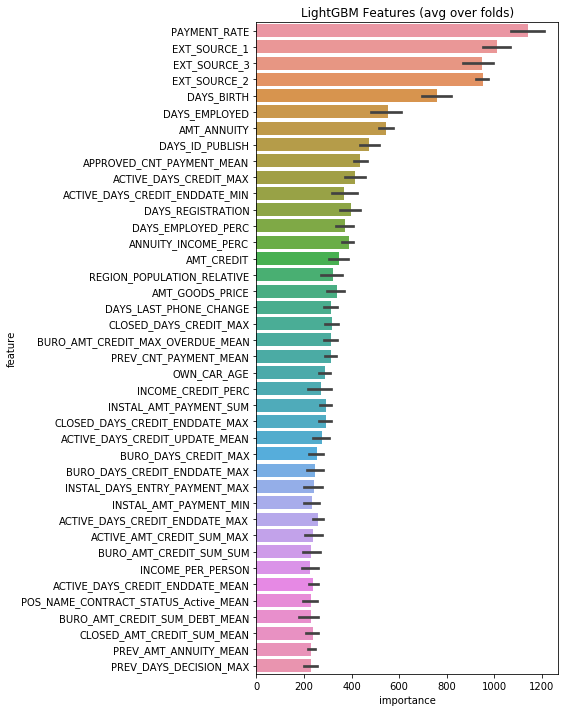

In [32]:
top_num = 600
feature_set_train = [v for v in variables[np.argsort(-scores)][0:top_num] if v != 'SK_ID_CURR'] # 0 is target
feature_set_test = [v for v in variables[np.argsort(-scores)][1:top_num] if v != 'SK_ID_CURR'] 
sub_train = full.query('TARGET.notna()')[feature_set_train].reset_index() # make 'SK_ID_CURR' a feature again
sub_test = full.query('TARGET.isna()')[feature_set_test].reset_index()
submission_file_name = "submission_0823_600.csv"
with timer("Full model run"):
    main(train_df=sub_train , test_df=sub_test)